<a href="https://colab.research.google.com/github/Nicohim87/DeepLearning-AOL/blob/main/AOL_DeepLearning_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [ ]:
import kagglehub

# Download latest version
DATASET_PATH = kagglehub.dataset_download("dionisiusdh/indonesian-batik-motifs")

print("Path to dataset files:", DATASET_PATH)

100%|██████████| 262M/262M [00:03<00:00, 71.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/dionisiusdh/indonesian-batik-motifs/versions/1


In [ ]:
img = tf.keras.utils.load_img(os.path.join(DATASET_PATH, 'batik-kawung/1.jpg'), color_mode='grayscale')
img = tf.keras.utils.img_to_array(img)
img.shape

(1772, 1776, 1)

In [ ]:
CHOSEN_CLASSNAME = ['batik-betawi', 'batik-kawung', 'batik-parang']
INPUT_SHAPE = (800, 800)

images = []
classes = []

In [ ]:
for i, classname in enumerate(CHOSEN_CLASSNAME):
    for j, filename in enumerate(os.listdir(os.path.join(DATASET_PATH, classname))):
        img = tf.keras.utils.load_img(os.path.join(DATASET_PATH, classname, filename), color_mode='grayscale', target_size=INPUT_SHAPE)
        img = tf.keras.utils.img_to_array(img)
        img = img/255
        images.append(img)
        classes.append(i)

In [ ]:
images = np.array(images)
classes = np.array(classes)

In [ ]:
y = tf.keras.utils.to_categorical(classes, num_classes=len(CHOSEN_CLASSNAME))
y.shape

(145, 3)

In [ ]:
images.shape

(145, 800, 800, 1)

# **Train Test Splitting**

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_temp, y_train, y_temp = train_test_split(images, y, test_size=0.7)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5)

[]

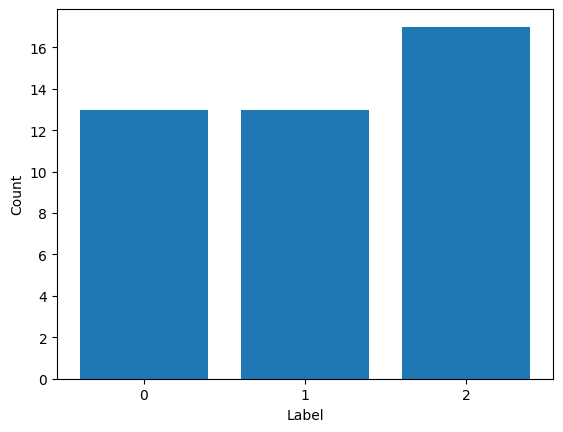

In [ ]:
ylabel = [np.argmax(i) for i in y_train]

label, count = np.unique(ylabel, return_counts=True) # Menghitung jumlah kemunculan dari suatu label
# Plotting
plt.bar(label, count)
plt.ylabel("Count")
plt.xlabel("Label")
plt.xticks(label)
plt.plot()

# **Augmentation**

In [ ]:
CLASS_SIZE = 50

In [ ]:
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)  # Random horizontal flip
    image = tf.image.random_flip_up_down(image)  # Random horizontal flip
    image = tf.image.random_brightness(image, max_delta=0.1)  # Random brightness
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)  # Random contrast
    return image, label

def generate_data(x_train, y_train, size):
    # Initial Shuffle
    permutation = np.random.permutation(len(x_train))

    x_train = x_train[permutation]
    y_train = y_train[permutation]

    # Data Generation
    permutation = np.random.permutation(size)
    permutation %= len(x_train)

    x_train_generated = []
    y_train_generated = []
    for i in permutation:
        x_gen, y_gen = augment_image(x_train[i], y_train[i])
        x_train_generated.append(x_gen)
        y_train_generated.append(y_gen)

    return x_train_generated, y_train_generated

In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)

x_train_augmented = []
y_train_augmented = []
for i in range(len(CHOSEN_CLASSNAME)):
    indices = np.where(y_train[:, i] == 1)[0]

    x_aug, y_aug = generate_data(x_train[indices], y_train[indices], CLASS_SIZE)
    x_train_augmented.extend(x_aug)
    y_train_augmented.extend(y_aug)

In [ ]:
x_train_augmented = np.array(x_train_augmented)
y_train_augmented = np.array(y_train_augmented)

permutation = np.random.permutation(len(x_train_augmented))

x_train_augmented = x_train_augmented[permutation]
y_train_augmented = y_train_augmented[permutation]

In [ ]:
x_train_augmented.shape

(150, 800, 800, 1)

[]

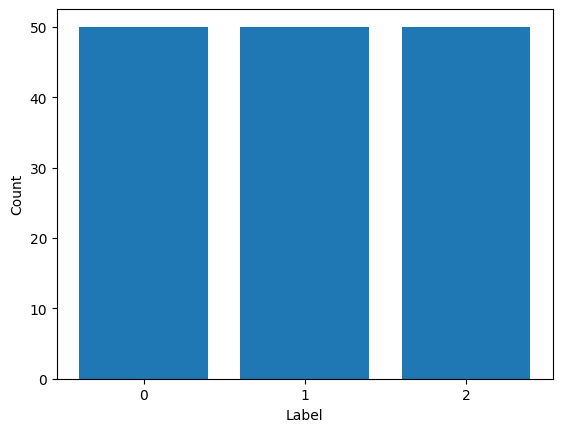

In [ ]:
ylabel = [np.argmax(i) for i in y_train_augmented]

label, count = np.unique(ylabel, return_counts=True) # Menghitung jumlah kemunculan dari suatu label
# Plotting
plt.bar(label, count)
plt.ylabel("Count")
plt.xlabel("Label")
plt.xticks(label)
plt.plot()

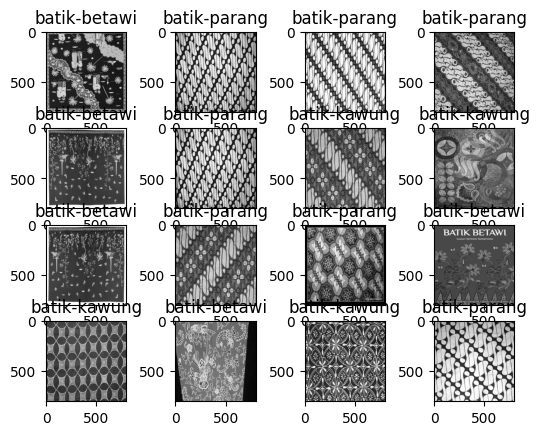

In [ ]:
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_train_augmented[i], cmap='gray')
    plt.title(CHOSEN_CLASSNAME[np.argmax(y_train_augmented[i])])

# **Model**

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
EPOCHS = 50
BATCH_SIZE = 15
LEARNING_RATE = 1e-5

In [ ]:
sobel_x = np.array([[1, 0, -1],[2, 0, -2], [1, 0, -1]], dtype=np.float32)
sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=np.float32)

sobel_x = sobel_x.reshape(3,3,1,1)
sobel_y = sobel_y.reshape(3,3,1,1)

In [ ]:

input = tf.keras.layers.Input(shape=x_train_augmented[0].shape)

edge_x = tf.keras.layers.Conv2D(1, (3,3),(1,1), padding='same',use_bias=False, trainable=False,kernel_initializer=tf.constant_initializer(sobel_x))(input)
edge_y = tf.keras.layers.Conv2D(1, (3,3),(1,1), padding='same',use_bias=False, trainable=False,kernel_initializer=tf.constant_initializer(sobel_y))(input)
x = tf.keras.layers.Lambda(lambda x: tf.sqrt(tf.square(x[0]) + tf.square(x[1])))([edge_x, edge_y])

x = tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)

x = tf.keras.layers.Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)

x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(128, activation='tanh')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(32)(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
x = tf.keras.layers.BatchNormalization()(x)

output = tf.keras.layers.Dense(len(CHOSEN_CLASSNAME), activation='softmax')(x)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
model= tf.keras.Model(inputs=input, outputs=output)


optimizer = Adam(learning_rate = LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 800, 800, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 800, 800, 1)    │              9 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 800, 800, 1)    │              9 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 800, 800, 1)    │              0 │ conv2d[0][0],          │
│                           │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 798, 798, 32)   │            320 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 399, 399, 32)   │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 397, 397, 16)   │          4,624 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 198, 198, 16)   │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 198, 198, 16)   │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 627264)         │              0 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │     80,289,920 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128)            │            512 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │          4,128 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 32)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32)             │            128 │ leaky_re_lu[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 3)              │             99 │ batch_normalization_1… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 80,299,749 (306.32 MB)

 Trainable params: 80,299,411 (306.32 MB)

 Non-trainable params: 338 (1.32 KB)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

hist = model.fit(x_train_augmented, y_train_augmented, validation_data = (x_val, y_val), epochs = EPOCHS, batch_size = BATCH_SIZE,  callbacks=[early_stopping])

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 151s 15s/step - accuracy: 0.5798 - loss: 0.8995 - val_accuracy: 0.3333 - val_loss: 1.3522
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 205s 16s/step - accuracy: 0.8588 - loss: 0.3980 - val_accuracy: 0.3333 - val_loss: 1.4030
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 152s 15s/step - accuracy: 0.9547 - loss: 0.2000 - val_accuracy: 0.3333 - val_loss: 1.4084
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 203s 15s/step - accuracy: 0.9733 - loss: 0.1752 - val_accuracy: 0.3137 - val_loss: 1.4713
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 203s 15s/step - accuracy: 0.9691 - loss: 0.1614 - val_accuracy: 0.3137 - val_loss: 1.4101
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 193s 14s/step - accuracy: 0.9904 - loss: 0.1061 - val_accuracy: 0.3137 - val_loss: 1.3624


# **Evaluation**

In [ ]:
from sklearn import metrics

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose = 1)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.2898 - loss: 1.4100
Loss: 1.407936453819275
Accuracy: 0.29411765933036804


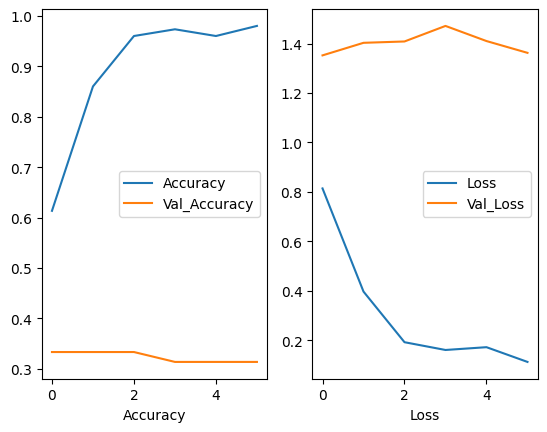

In [ ]:
# Accuracy
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('Epochs')
plt.xlabel('Accuracy')
plt.legend(['Accuracy', "Val_Accuracy"])

# Loss
plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('Epochs')
plt.xlabel('Loss')
plt.legend(['Loss', "Val_Loss"])

# Tampilkan Plot
plt.show()

In [ ]:
pred = model.predict(x_test) # Flatten untuk memastikan bahwa output hanya berupa 1D array

pred = [CHOSEN_CLASSNAME[np.argmax(i)] for i in pred] # Mendecode hasil prediksi nya, index perlu di bulatkan karena fungsi sigmoid normalnya tidak menghasilkan bilangan bulat
actual = [CHOSEN_CLASSNAME[np.argmax(i)] for i in y_test] # Mendecode nilai asli nya

2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 6s/step


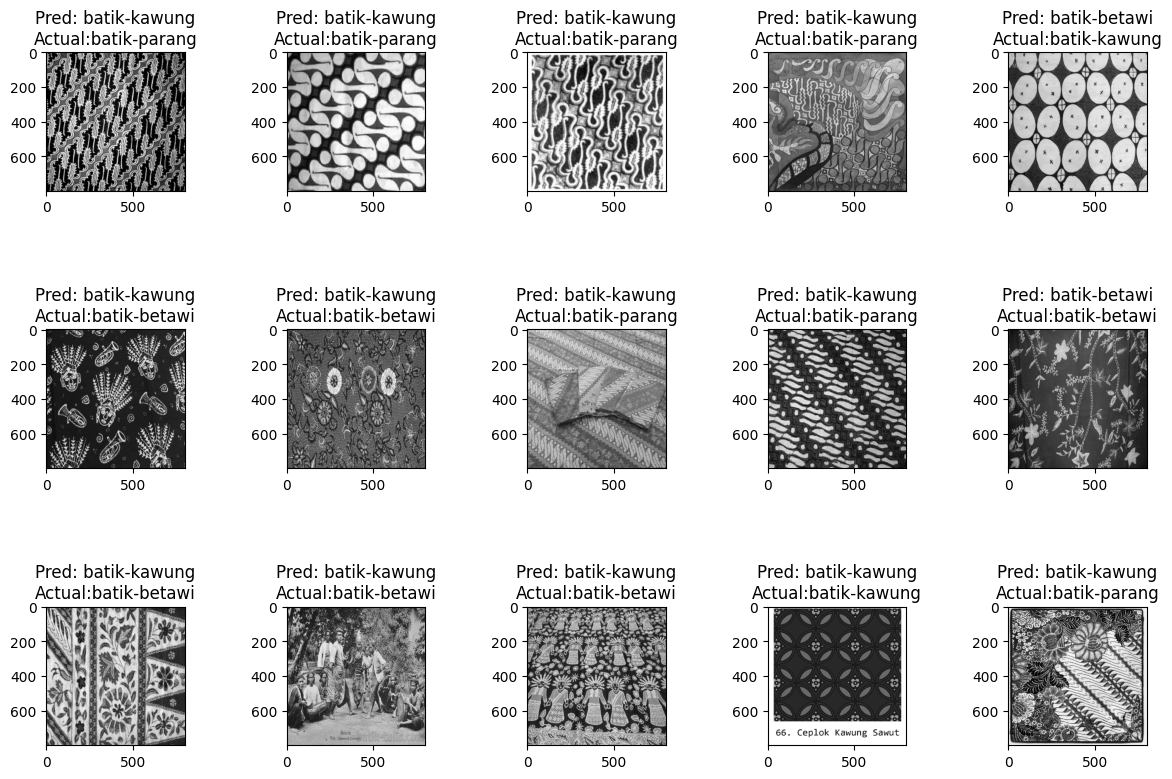

In [ ]:
plt.figure(figsize=(15,9)) # Menentukan ukuran plot
for i in range(15):
    plt.subplot(3, 5, i+1) # Menentukan lokasi subplot nya
    plt.imshow(x_test[i], cmap='gray') # Menampilkan gambar

    plt.title(f"Pred: {pred[i]}\nActual:{actual[i]}") # Menampilkan actual value dan prediction nya

plt.subplots_adjust(hspace=1)

In [ ]:
print(metrics.classification_report(pred, actual))

              precision    recall  f1-score   support

batik-betawi       0.12      0.40      0.18         5
batik-kawung       0.81      0.28      0.42        46
batik-parang       0.00      0.00      0.00         0

    accuracy                           0.29        51
   macro avg       0.31      0.23      0.20        51
weighted avg       0.74      0.29      0.40        51



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


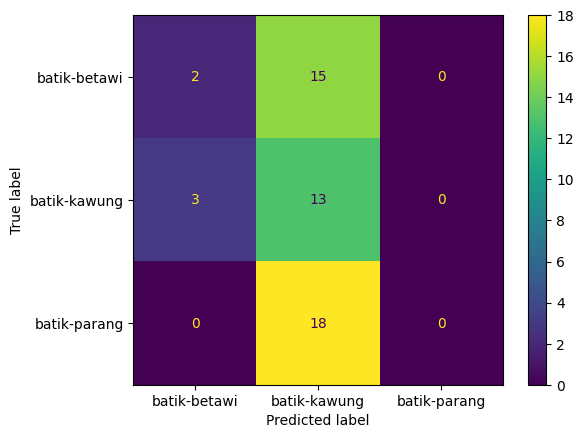

In [ ]:
CM = metrics.confusion_matrix(actual, pred) # Membuat confusion matrix nya
fig = metrics.ConfusionMatrixDisplay(CM, display_labels=CHOSEN_CLASSNAME) # Display labels agar label yang ditunjukan sudah di decode
fig.plot() # Plot confusion matrix nya